In [1]:
%pip install qiskit sympy matplotlib numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler
from qiskit.quantum_info import Statevector
from sympy import symbols, sqrt, simplify, init_printing
import matplotlib.pyplot as plt
import numpy as np
import sys

np.set_printoptions(threshold=sys.maxsize)

In [3]:
class keyGen():
    def __init__(self, shots=1):
        self.qcEnt = QuantumCircuit(2, 2)
        self.entengledQc = self.qcEntengledCreate()
        self.counts = {}
        self.shots = shots
        self.sim = StatevectorSampler()
        self.mesurements = {
            (0, 0): "0000",
            (1, 0): "M3000",
            (0, 1): "0030",
            (1, 1): "M3030"
        }

    def qcEntengledCreate(self):
        self.qcEnt.h(1)
        self.qcEnt.cx(1, 0)
        self.qcEnt.swap(0, 1)
        self.qcEnt.y(0)
        print("--------------------")
        print("entengledQc")
        print(self.qcEnt.draw())
        def format_statevector(state):
            basis_states = [f"|{bin(i)[2:].zfill(state.num_qubits)}⟩" for i in range(2**state.num_qubits)]
            terms = []
            for amplitude, basis in zip(state.data, basis_states):
                if abs(amplitude) > 1e-10:  # Ignorer les termes de coefficient proche de 0
                    # Simplifier les coefficients avec SymPy
                    coeff = simplify(amplitude)
                    terms.append(f"{coeff} {basis}")
            # Rejoindre les termes avec des "+" entre eux
            return " + ".join(terms)
        state = Statevector.from_instruction(self.qcEnt)
        formatted_state = format_statevector(state)
        print("État quantique :", formatted_state)
        print("--------------------")
        return (self.qcEnt.copy())

    def qcMesureCreate(self, A_Angle, B_Angle):
        qcM = QuantumCircuit(2, 2)
        qcM.ry(2 * A_Angle, 0)
        qcM.ry(2 * B_Angle, 1)
        qcM.measure([0, 1], [0, 1])
        print("--------------------")
        print("mesureQc")
        print(qcM.draw())
        print("--------------------")
        return (qcM)

    def wCalc(self, results, random_settings):
        # print("--------------------")
        # print("wCalc")
        # for r, s in zip(results, random_settings):
        #     print(f"result: {r}, setting: {s}")
        # print("--------------------")
        pM3000 = sum([1 for r, s in zip(results, random_settings) if s == "M3000" and '00' in r]) / len(results)
        p0030 = sum([1 for r, s in zip(results, random_settings) if s == "0030" and '00' in r]) / len(results)
        pM3030 = sum([1 for r, s in zip(results, random_settings) if s == "M3030" and '00' in r]) / len(results)

        W = pM3000 + p0030 - pM3030
        # print("--------------------")
        # print(W, pM3000, p0030, pM3030, "\n\n" ,results, "\n\n", random_settings)
        # print("--------------------")

        return [W, pM3000, p0030, pM3030]

    def run(self):
        a = np.random.randint(2, size=1024)
        b = np.random.randint(2, size=1024)
        # print("--------------------")
        # print(f"a: {a}\n\nb: {b}")
        # print("--------------------")

        circuits = {
            "0000": self.qcMesureCreate(0, 0),
            "M3000": self.qcMesureCreate(np.radians(-30), 0),
            "0030": self.qcMesureCreate(0, np.radians(30)),
            "M3030": self.qcMesureCreate(np.radians(-30), np.radians(30))
        }

        first = False
        random_settings = [self.mesurements[(c, d)] for c, d in zip(a, b)]

        retVals = []
        while True:
            results = []
            for setting in random_settings:
                qc = self.entengledQc.compose(circuits[setting])
                job = self.sim.run([qc], shots=self.shots).result()[0]
                result = job.data.c.get_counts()
                results.append(result)
            retCalc = self.wCalc(results, random_settings)
            if (first == False):
                key = [r for r, s in zip(results, random_settings) if s == "0000"]
                print(f"key: {key}")
                print(f"prob: p(m30, 0) = {retCalc[1]}, p(0, 30) = {retCalc[2]}, p(m30, 30) = {retCalc[3]}")
                print(f"W: {retCalc[0]}")
                first = True

            retVals.append(retCalc[0])
            plt.plot(retVals)
            plt.xlabel("Batch ID")
            plt.ylabel("W")
            plt.show()

            if (retCalc[0] > 0.01 and first == True):
                print("listening")
            if input("Continue (O/n) : ").lower() == 'n':
                break

--------------------
entengledQc
          ┌───┐   ┌───┐
q_0: ─────┤ X ├─X─┤ Y ├
     ┌───┐└─┬─┘ │ └───┘
q_1: ┤ H ├──■───X──────
     └───┘             
c: 2/══════════════════
                       
État quantique : 0.707106781186547*I |01⟩ + -0.707106781186547*I |10⟩
--------------------
--------------------
mesureQc
     ┌───────┐┌─┐   
q_0: ┤ Ry(0) ├┤M├───
     ├───────┤└╥┘┌─┐
q_1: ┤ Ry(0) ├─╫─┤M├
     └───────┘ ║ └╥┘
c: 2/══════════╩══╩═
               0  1 
--------------------
--------------------
mesureQc
     ┌──────────┐┌─┐   
q_0: ┤ Ry(-π/3) ├┤M├───
     └┬───────┬─┘└╥┘┌─┐
q_1: ─┤ Ry(0) ├───╫─┤M├
      └───────┘   ║ └╥┘
c: 2/═════════════╩══╩═
                  0  1 
--------------------
--------------------
mesureQc
      ┌───────┐ ┌─┐   
q_0: ─┤ Ry(0) ├─┤M├───
     ┌┴───────┴┐└╥┘┌─┐
q_1: ┤ Ry(π/3) ├─╫─┤M├
     └─────────┘ ║ └╥┘
c: 2/════════════╩══╩═
                 0  1 
--------------------
--------------------
mesureQc
     ┌──────────┐┌─┐   
q_0: ┤ Ry(-π/3) ├┤M├───
 

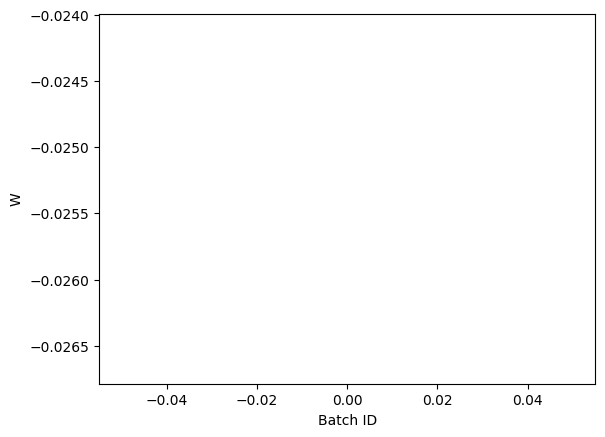

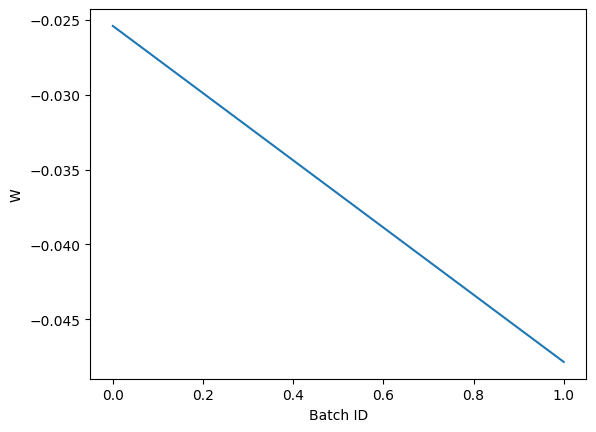

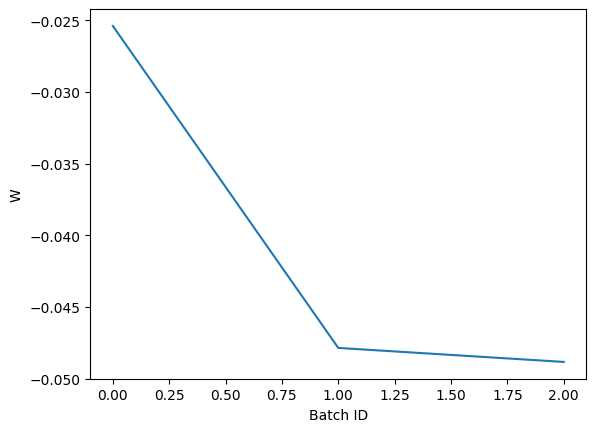

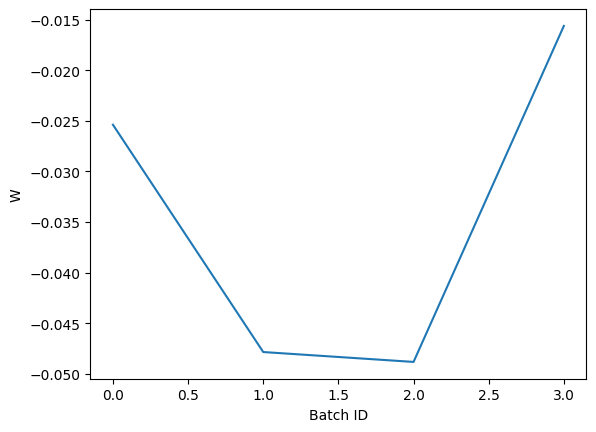

In [4]:
gen = keyGen()
gen.run()